In [239]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from glob import glob

from sklearn.metrics import r2_score
from scipy import stats

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# load inpainting data from the inpainting notebook(s)

In [240]:
# debug_0_5000_1_1e-1_c , Same inpainting settings as ExoGAN

general_name = 'debug_0_5000_1_1e-1_c' # general filename, e.g. 'test' for test_reals.npy, test_inpainteds.npy... etc.

# get the file paths of the result files
reals = glob('gan_data//val_errors//'+general_name+'_reals.npy')
inpainteds = glob('gan_data//val_errors//'+general_name+'_inpainteds.npy')
n_iterations = glob('gan_data//val_errors//'+general_name+'_n_iterations.npy')


contextuals = glob('gan_data//val_errors//'+general_name+'_contextual_losses.npy')
perceptuals = glob('gan_data//val_errors//'+general_name+'_perceptual_losses.npy')

reals

['gan_data//val_errors//debug_0_5000_1_1e-1_c_reals.npy']

In [241]:
# load arrays to list, convert list to ndarray with shape (aspa, n_inpaintings, height, width)
reals = np.concatenate([np.load(path) for path in reals], axis=0)
inpainteds = np.concatenate([np.load(path) for path in inpainteds], axis=0)

perceptuals = np.concatenate([np.load(path) for path in perceptuals], axis=0)
contextuals = np.concatenate([np.load(path) for path in contextuals], axis=0)

# take mean of the n_inpaintings per aspa
n_aspas = reals.shape[0]
reals = reals.mean(axis=1).reshape(n_aspas,1,32,32)
inpainteds = inpainteds.mean(axis=1).reshape(n_aspas,1,32,32)

In [242]:
reals.shape

(5000, 1, 32, 32)

In [243]:
reals.mean(1).shape

(5000, 32, 32)

# Error of ASPA $i$

In [245]:
i = 3739

decodeds =[ke.decode_params_from_aspa(inpainteds[i, j]) for j in range(reals.shape[1])]

df = pd.DataFrame.from_dict(decodeds)
df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

df.describe()

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
count,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.00000
mean,-5.153906,-1.336583,-9.315235,-3.512732,3.093763e+27,1.056634e+08,1727.726996,-0.083843,20.96563
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-5.153906,-1.336583,-9.315235,-3.512732,3.093763e+27,1.056634e+08,1727.726996,-0.083843,20.96563
25%,-5.153906,-1.336583,-9.315235,-3.512732,3.093763e+27,1.056634e+08,1727.726996,-0.083843,20.96563
50%,-5.153906,-1.336583,-9.315235,-3.512732,3.093763e+27,1.056634e+08,1727.726996,-0.083843,20.96563
75%,-5.153906,-1.336583,-9.315235,-3.512732,3.093763e+27,1.056634e+08,1727.726996,-0.083843,20.96563
max,-5.153906,-1.336583,-9.315235,-3.512732,3.093763e+27,1.056634e+08,1727.726996,-0.083843,20.96563


In [246]:
df

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
0,-5.153906,-1.336583,-9.315235,-3.512732,3.093763e+27,1.056634e+08,1727.726996,-0.083843,20.96563


In [247]:
if reals.shape[1] > 1 :
    params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

    fontsize = 16
    plt.figure(figsize=((25,10)))
    for i,param in enumerate(params):
        plt.subplot(3,3,i+1)
        plt.title(param, fontsize=fontsize)
        plt.hist(df[param], bins=25)

        # plot mean and median line
        mu = df[param].mean()
        plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
        plt.axvline(x=df[param].median(),  color='black', linestyle='-', alpha=1, label='median')

        # plot std lines
        plt.axvline(x=mu-df[param].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
        plt.axvline(x=mu+df[param].std(),  color='black', linestyle=':', alpha=1)

        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.xlabel('Percentage error [%]', fontsize=fontsize)
        plt.ylabel('Counts [-]', fontsize=fontsize)

        plt.legend(fontsize=fontsize)
        plt.grid()
        plt.tight_layout()

In [248]:
reals.shape

(5000, 1, 32, 32)

In [249]:
#reals = reals.mean(axis=1) # take the mean of n_inpaintings per aspa, new shape is (aspa, height, width)
#inpainteds = inpainteds.mean(axis=1)

#reals = reals.reshape(reals.shape[0]*reals.shape[1], 32,32)
#inpainteds = inpainteds.reshape(inpainteds.shape[0]*inpainteds.shape[1], 32,32)

#from scipy import stats
#df = df[(np.abs(stats.zscore(df)) < 1).all(axis=1)]

reals.shape

(5000, 1, 32, 32)

In [250]:
reals[0].shape

(1, 32, 32)

## Spectrum plot

In [251]:
real = reals[i][0]
inpainted = inpainteds[i][0]

real.shape, inpainted.shape

((32, 32), (32, 32))

In [252]:
real_spec = real[:16, :25].flatten()
inpainted_spec = inpainted[:16, :25].flatten()

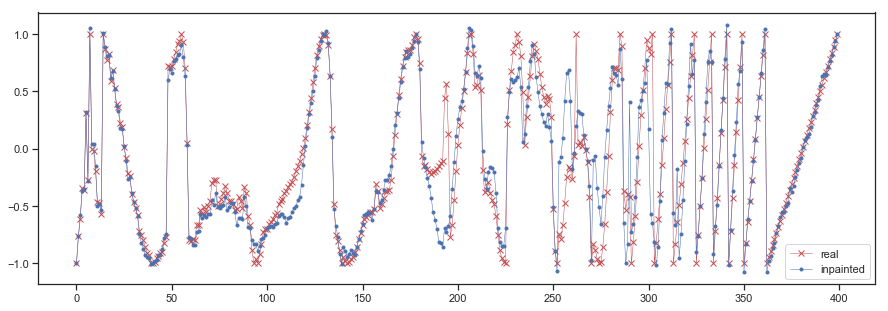

In [279]:
# :16, :25 is the spectrum location within the ASPA
plt.figure(figsize=(15,5))
plt.plot(real_spec, 'x-', c='r', linewidth=0.5, label='real')
plt.plot(inpainted_spec, '.-', linewidth=0.5, label='inpainted')
plt.legend()

# Pixel difference plot

Text(0, 0.5, '$y$-$\\hat{y}$')

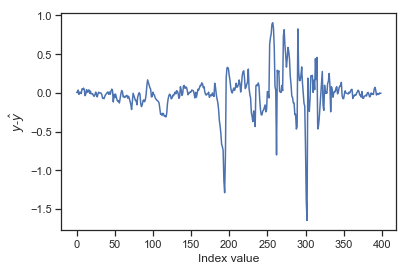

In [254]:
plt.plot(inpainted_spec - real_spec)
plt.xlabel('Index value')
plt.ylabel(r'$y$-$\hat{y}$')

/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:370: RuntimeWarning: Mean of empty slice.
  mins_ = [aspa[16:17, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:371: RuntimeWarning: Mean of empty slice.
  maxs_ = [aspa[17:18, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


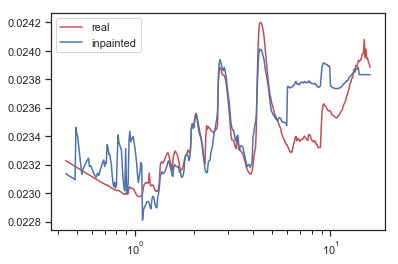

In [255]:
xhat,yhat = ke.decode_spectrum_from_aspa(real)
x,y  = ke.decode_spectrum_from_aspa(inpainted)

plt.plot(xhat, yhat, label='real', c='r')
plt.plot(x,y,label='inpainted')

plt.gca().set_xscale('log')

plt.legend()

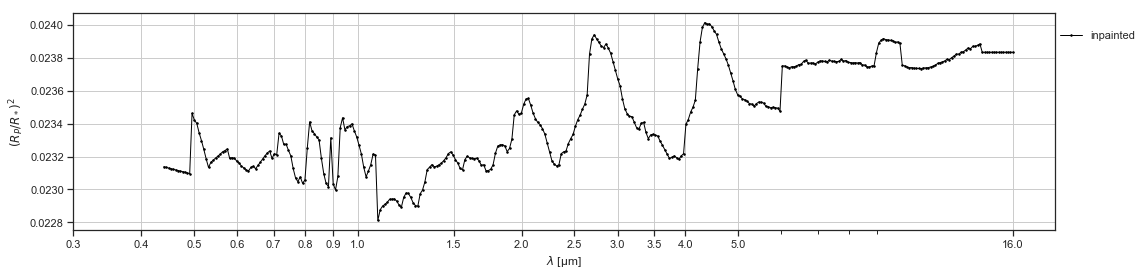

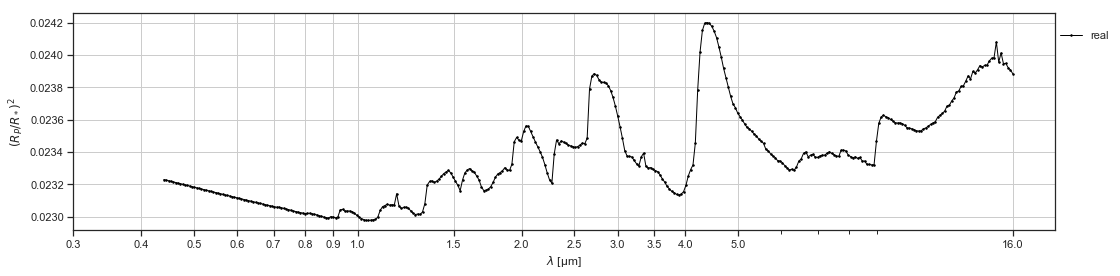

In [256]:
ke.plot_trans(x,y, label='inpainted')
ke.plot_trans(xhat,yhat, label='real')

# Error of all ASPAs

In [257]:
reals.shape

(5000, 1, 32, 32)

In [258]:
reals = [ke.decode_params_from_aspa(real[0]) for real in reals]
inpainteds = [ke.decode_params_from_aspa(inpainted[0]) for inpainted in inpainteds]

In [259]:
# create dfs for real, inpainted and their percentage errors

reals = pd.DataFrame.from_dict(reals)
inpainteds = pd.DataFrame.from_dict(inpainteds)
errors = (inpainteds - reals) / reals * 100

In [260]:
contextuals.shape

(5000,)

In [261]:
errors = errors.replace([np.inf, -np.inf], np.nan) # TODO: Fix the occurance of inf, this has to do with 0 Kelvin values

reals.columns = [column+'_real' for column in reals.columns]
inpainteds.columns = [column+'_inpainted' for column in inpainteds.columns]
errors.columns = [column+'_error' for column in errors.columns]

## Errors df

In [262]:
errors.describe()

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-3.151007,-6.348706,21.480013,2.678406,6.126677,-0.968800,5.366663
std,34.728042,34.436180,102.660316,37.316998,37.850949,2.272796,30.888094
min,-81.027504,-83.388621,-96.365803,-75.367733,-65.092203,-21.593874,-55.619442
25%,-11.477027,-12.991441,-22.302350,-5.052445,-20.770137,-2.084772,-16.548984
50%,-0.662984,-0.847415,0.751761,1.173006,-0.342036,-0.849646,0.925046
75%,4.314974,2.958960,24.703187,6.688768,26.238048,0.377076,23.728535
max,357.140594,618.866947,866.221970,495.814899,152.024004,9.612731,109.662962


In [263]:
errors[:10]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
0,-0.868005,0.922413,3.698245,-0.510875,115.526215,-0.163392,74.687637
1,-1.785400,2.027671,29.396471,-3.135547,-38.320987,0.945456,-17.586423
2,-0.587566,-0.780537,46.650902,58.920718,-29.675125,0.760543,26.820814
3,18.628351,-3.438907,8.388418,1.933612,26.920214,-0.379698,-1.079601
4,-0.173820,4.846522,6.974730,3.800595,-39.900219,-0.205264,-19.078477
5,3.122568,-3.609626,59.273925,-8.304046,-46.234744,-1.180053,-29.357914
6,5.695779,-0.596710,11.261621,2.022274,16.632217,1.818940,-3.259586
7,40.024350,14.381683,6.893474,0.150227,5.782495,-0.118162,-28.489162
8,8.436942,-12.661885,-34.290189,0.859067,13.761139,-1.231933,27.184128
9,155.140525,86.329402,-24.801751,-10.228544,57.228072,-2.177635,15.678374


In [264]:
errors[(errors.co_mixratio_error > 800) | (errors.co_mixratio_error < -800)]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
1420,86.340182,20.312385,866.221970,22.902458,0.673913,-2.709967,2.993799
3739,-20.025595,-59.902499,831.523538,-28.148670,22.250920,0.759872,-8.532101


In [265]:
### join the dfs together
df = reals.join(inpainteds, how='outer')
df = df.join(errors, how='outer')

df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

In [266]:
df.describe()

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
count,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-4.470756,-4.502178,-4.495022,-4.507467,2.657200e+27,8.037590e+07,1509.911111,-4.309744,-4.210794,-4.498206,...,1525.232080,-3.151007,-6.348706,21.480013,2.678406,6.126677,-0.968800,5.366663,-0.056903,24.141308
std,2.229691,2.255405,2.243080,2.267167,7.256637e+26,1.557376e+07,318.346138,2.496350,2.466568,2.283933,...,319.495451,34.728042,34.436180,102.660316,37.316998,37.850949,2.272796,30.888094,0.035005,22.970093
min,-8.000000,-8.000000,-8.000000,-8.000000,1.518400e+27,5.592880e+07,1000.000000,-8.517958,-8.999768,-10.461064,...,810.613036,-81.027504,-83.388621,-96.365803,-75.367733,-65.092203,-21.593874,-55.619442,-0.208103,8.434791
25%,-6.444445,-6.444445,-6.444445,-6.444445,2.024533e+27,6.680384e+07,1222.222209,-6.979641,-6.484608,-6.390462,...,1244.979665,-11.477027,-12.991441,-22.302350,-5.052445,-20.770137,-2.084772,-16.548984,-0.080055,12.807046
50%,-4.111111,-4.888889,-4.111111,-4.111111,2.530667e+27,7.767889e+07,1555.555556,-4.109243,-4.063062,-4.515786,...,1572.960608,-0.662984,-0.847415,0.751761,1.173006,-0.342036,-0.849646,0.925046,-0.056532,16.265313
75%,-2.555555,-2.555555,-2.555555,-2.555555,3.289867e+27,9.399146e+07,1777.777791,-1.834406,-1.805408,-2.446419,...,1800.149724,4.314974,2.958960,24.703187,6.688768,26.238048,0.377076,23.728535,-0.028869,23.110132
max,-1.000000,-1.000000,-1.000000,-1.000000,3.796000e+27,1.048665e+08,2000.000000,-0.721063,-0.812112,-0.092874,...,2258.007705,357.140594,618.866947,866.221970,495.814899,152.024004,9.612731,109.662962,0.000467,202.713837


In [267]:
df[:10]

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
0,-8.000000,-6.444445,-6.444445,-5.666667,1.771467e+27,8.855393e+07,1000.000000,-7.930560,-6.503889,-6.682776,...,1746.876374,-0.868005,0.922413,3.698245,-0.510875,115.526215,-0.163392,74.687637,-0.083843,20.965630
1,-4.111111,-5.666667,-1.000000,-4.111111,3.036800e+27,6.136632e+07,2000.000000,-4.037711,-5.781568,-1.293965,...,1648.271531,-1.785400,2.027671,29.396471,-3.135547,-38.320987,0.945456,-17.586423,-0.086114,16.936975
2,-2.555555,-2.555555,-4.888889,-4.888889,1.771467e+27,9.942898e+07,1666.666672,-2.540540,-2.535608,-7.169600,...,2113.680243,-0.587566,-0.780537,46.650902,58.920718,-29.675125,0.760543,26.820814,-0.091555,14.635529
3,-6.444445,-6.444445,-8.000000,-2.555555,1.518400e+27,8.855393e+07,1777.777791,-7.644938,-6.222826,-8.671073,...,1758.584887,18.628351,-3.438907,8.388418,1.933612,26.920214,-0.379698,-1.079601,-0.056491,15.358067
4,-4.111111,-1.777778,-1.000000,-2.555555,3.542933e+27,7.224137e+07,1777.777791,-4.103965,-1.863938,-1.069747,...,1438.604869,-0.173820,4.846522,6.974730,3.800595,-39.900219,-0.205264,-19.078477,-0.112179,13.868361
5,-1.000000,-7.222222,-4.111111,-8.000000,3.542933e+27,6.680384e+07,1555.555556,-1.031226,-6.961527,-6.547928,...,1098.876894,3.122568,-3.609626,59.273925,-8.304046,-46.234744,-1.180053,-29.357914,-0.061485,10.123037
6,-7.222222,-4.111111,-7.222222,-3.333333,1.518400e+27,8.855393e+07,1222.222209,-7.633584,-4.086580,-8.035562,...,1182.382822,5.695779,-0.596710,11.261621,2.022274,16.632217,1.818940,-3.259586,-0.087995,11.472429
7,-4.888889,-2.555555,-8.000000,-4.888889,2.277600e+27,8.855393e+07,1888.888896,-6.845635,-2.923087,-8.551478,...,1350.760281,40.024350,14.381683,6.893474,0.150227,5.782495,-0.118162,-28.489162,-0.069807,66.525055
8,-1.000000,-8.000000,-3.333333,-4.111111,3.036800e+27,7.767889e+07,1111.111104,-1.084369,-6.987049,-2.190327,...,1413.156971,8.436942,-12.661885,-34.290189,0.859067,13.761139,-1.231933,27.184128,-0.055687,13.054408
9,-1.000000,-4.111111,-6.444445,-8.000000,1.771467e+27,7.767889e+07,1555.555556,-2.551405,-7.660209,-4.846109,...,1799.441367,155.140525,86.329402,-24.801751,-10.228544,57.228072,-2.177635,15.678374,-0.027627,31.088978


In [268]:
#df = df.drop(['temp_profile_error','temp_profile_real','temp_profile_inpainted'], axis=1)

# Percentage error histograms per retrieved parameter

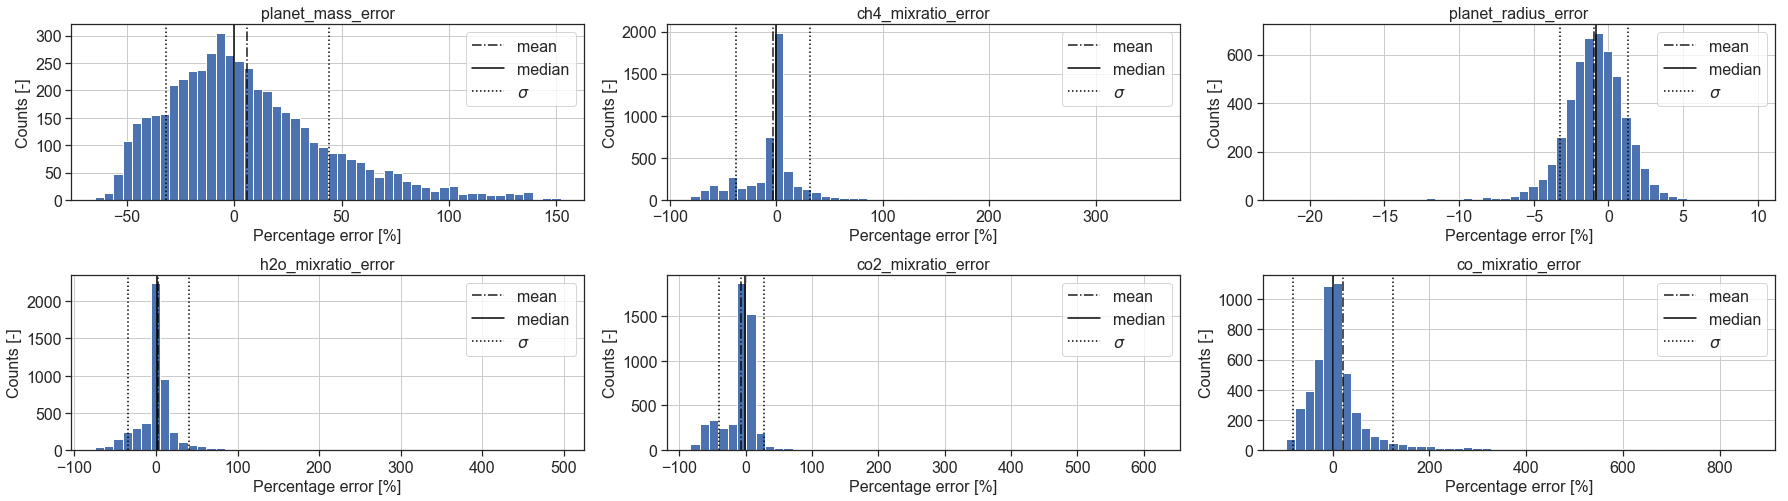

In [269]:
#params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']
params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

fontsize = 16
plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error', fontsize=fontsize)
    plt.hist(df[param+'_error'], bins=50)
    
    # plot mean and median line
    mu = df[param+'_error'].mean()
    plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
    plt.axvline(x=df[param+'_error'].median(),  color='black', linestyle='-', alpha=1, label='median')

    # plot std lines
    plt.axvline(x=mu-df[param+'_error'].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
    plt.axvline(x=mu+df[param+'_error'].std(),  color='black', linestyle=':', alpha=1)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel('Percentage error [%]', fontsize=fontsize)
    plt.ylabel('Counts [-]', fontsize=fontsize)
    
    plt.legend(fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

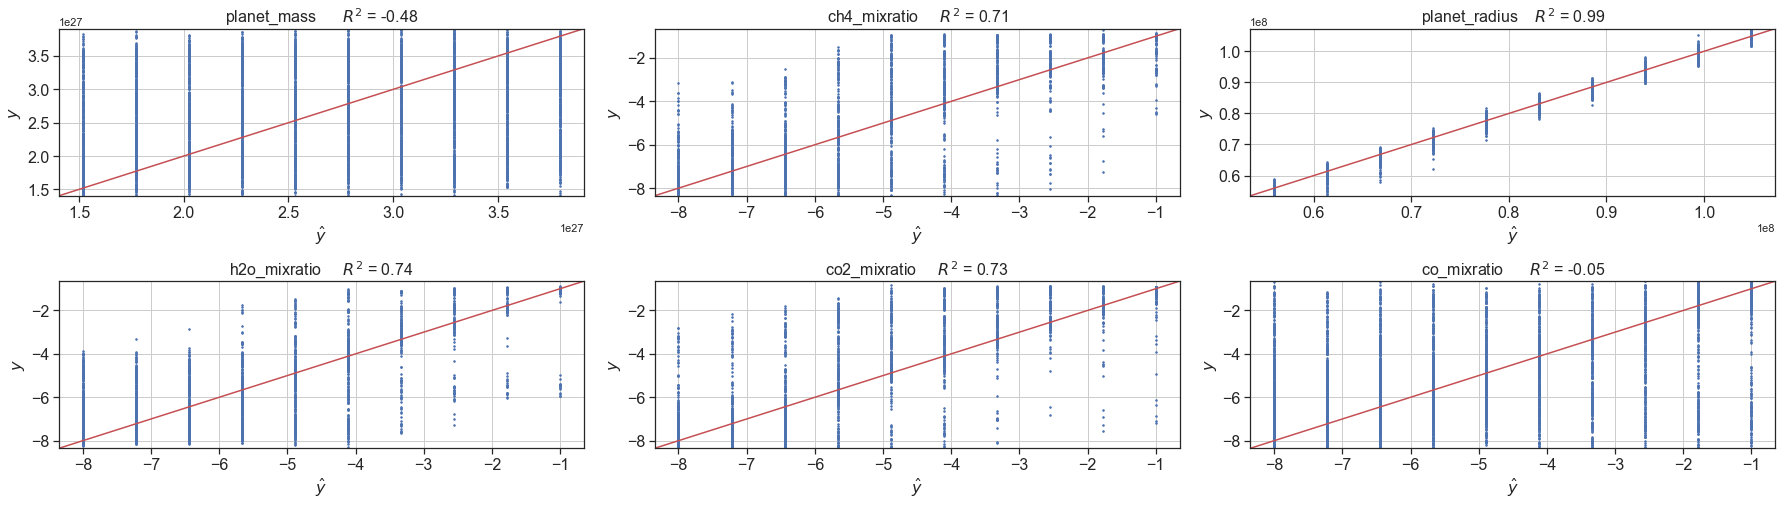

In [270]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)

    plt.title(param +' \t $R^2$ = %.2f' % r2, fontsize=fontsize)
    plt.plot(y_hat, y, '.', ms=3)
    
    """Force x,y range on the same scale outliers outside of range wont be plotted!"""
    x_min, x_max = plt.xlim()
    x_min = x_min*1
    x_max = x_max*1
    
    plt.ylim((x_min, x_max)) # set y axis range the same as x axis range
    plt.xlim((x_min, x_max))
    
    # Plot the red 'perfect' prediction line
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel(r"$\hat{y}$", fontsize=fontsize)
    plt.ylabel(r"$y$", fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# 1$\sigma$ percentage error per parameter

### Unique values STD plot
y axis, STD  
X axis, unique values  

This plot shows the STD per parameter value (10 values for ExoGAN data)

Horizontal -. line is the 10% line

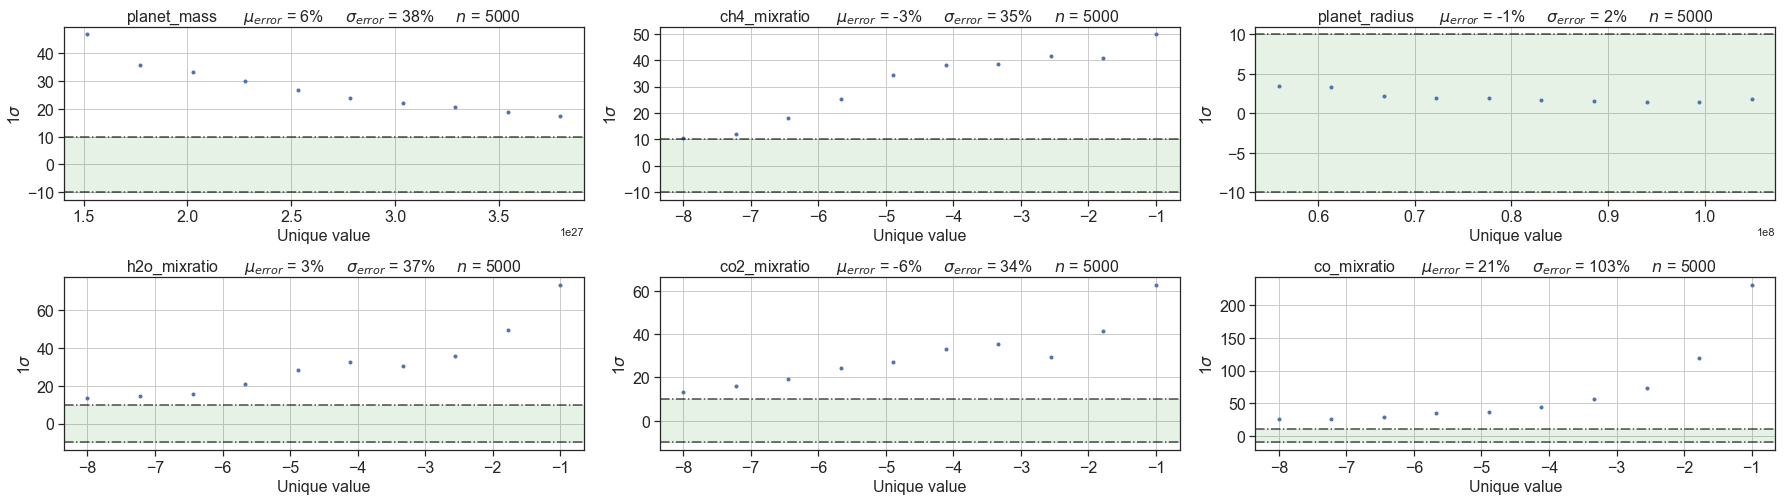

In [271]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    uniques = df[param+'_real'].unique()
    
    counts = []
    stds = []
    for unique in uniques:
        t = df[param+'_error'][(df[param+'_real'] == unique)]
        std = t.std()
        count = t.count()
        #print(count, std)

        counts.append(count)
        stds.append(std)

    plt.subplot(3,3,i+1)
    plt.plot(uniques, stds, '.')
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Unique value', fontsize=fontsize)
    plt.ylabel(r'1$\sigma$', fontsize=fontsize)
    plt.tight_layout()
    

In [272]:
iters = [np.load(iters) for iters in n_iterations]
iters

[array([], dtype=float64)]

In [273]:
uniques

array([-6.44444454, -1.        , -4.88888889, -8.        , -4.11111111,
       -7.22222227, -3.3333333 , -2.55555546, -5.6666667 , -1.77777773])

# Losses

In [274]:
df[['perceptuals', 'contextuals']].describe()

,perceptuals,contextuals
count,5000.000000,5000.000000
mean,-0.056903,24.141308
std,0.035005,22.970093
min,-0.208103,8.434791
25%,-0.080055,12.807046
50%,-0.056532,16.265313
75%,-0.028869,23.110132
max,0.000467,202.713837


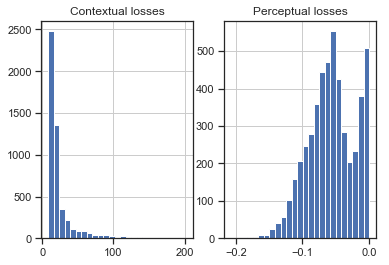

In [275]:
plt.subplot(1,2,1)
plt.hist(df.contextuals, bins=25)
plt.title('Contextual losses')
plt.grid()

plt.subplot(1,2,2)
plt.hist(df.perceptuals, bins=25)
plt.title('Perceptual losses')
plt.grid()

# Param percentage errors vs contextual loss
For contextual loss, lower is better.

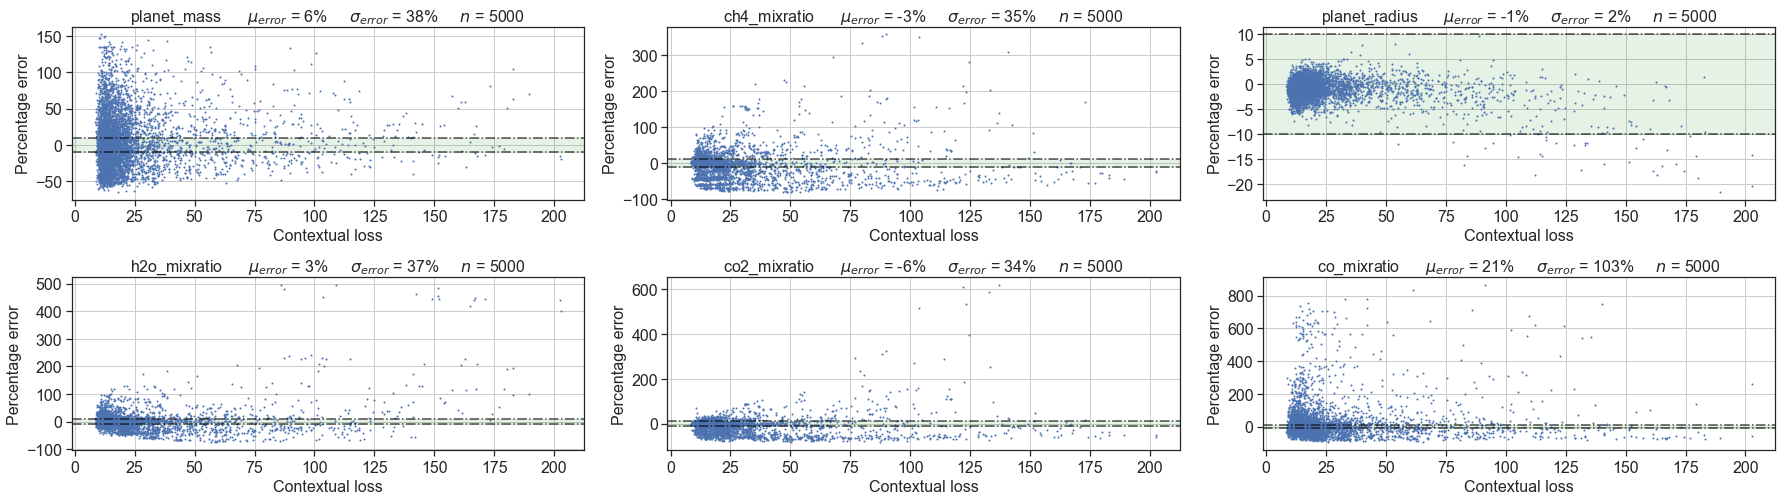

In [276]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.contextuals, df[param+'_error'], '.', ms=2)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    #plt.ylim((-100,100))
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Contextual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    #plt.legend()
    plt.tight_layout()
    

# Param percentage errors vs perceptual loss
For perceptual loss, lower is better.

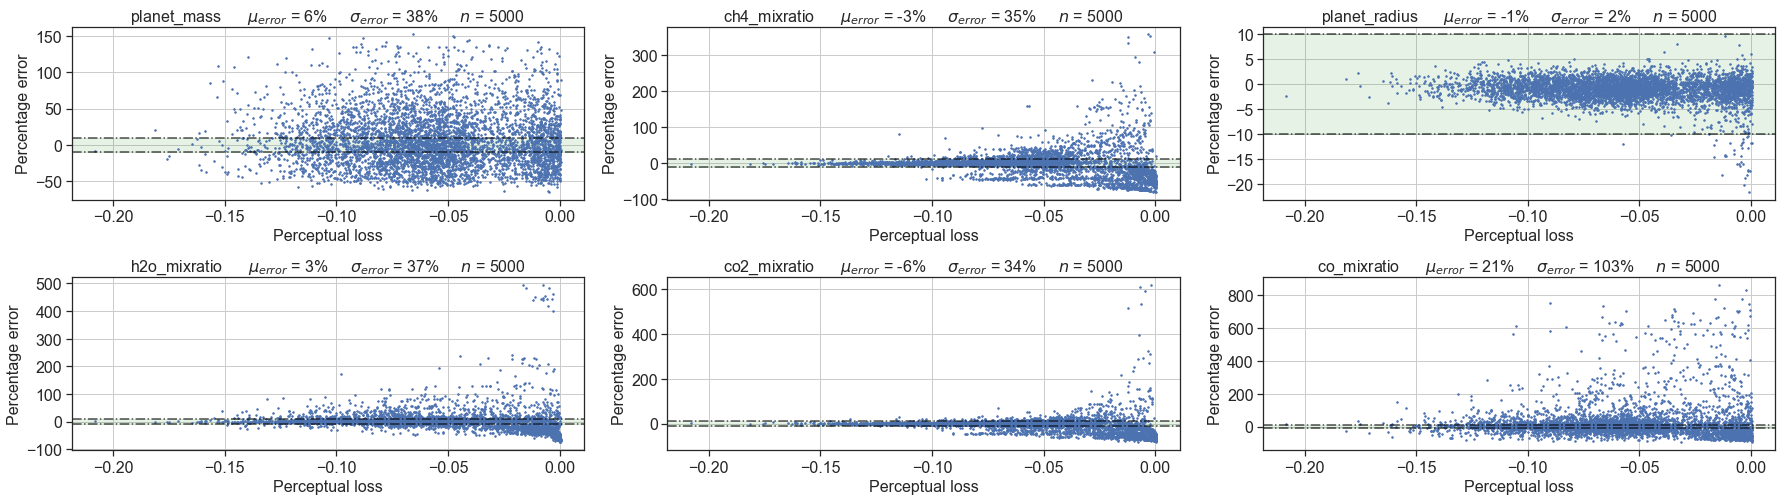

In [277]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.perceptuals, df[param+'_error'], '.', ms=3)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Perceptual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    plt.tight_layout()